In [1]:
# Here is the sample code that I have used for scraping news site.
# news_spider.py

# This module scrolls through news site (ekantipur.com) and collects news titles.
import time
import csv

from bs4 import BeautifulSoup

from selenium import webdriver
from selenium.webdriver.common.keys import Keys

browser = webdriver.Chrome()

browser.get("http://www.ekantipur.com/eng")
time.sleep(1)

elem = browser.find_element_by_tag_name("body")

# set number of pages be scrolled
no_of_pagedowns = 5

# scroll page (handling infinite page scrolling)
while no_of_pagedowns:
    elem.send_keys(Keys.PAGE_DOWN)
    time.sleep(0.2)
    no_of_pagedowns -= 1

content = browser.page_source
soup = BeautifulSoup(content, "html5lib")
browser.close()

news_title_containers = soup.find_all(
    "div", attrs={'class': 'display-news-title'})
with open('news_titles.csv', 'w') as csv_file:
    writer = csv.writer(csv_file)
    for each_container in news_title_containers:
        title_link = each_container.find('a')
        news_title = title_link.string.strip()
        writer.writerow([news_title])


I have divided the whole model development process into following subprocesses:

 #### A. Loading data / Split into training and test set

I have divided the collected data by 80/20 for training and testing.


In [1]:
import pandas as pd
pd.set_option('display.max_colwidth', -1)
from sklearn.model_selection import train_test_split

data = pd.read_csv(
    'news_corpus/data.csv',names=['text', 'label'],
    dtype={'label': object})
data.head(5)


text label
0  Business growth in euro zone rises to 32-month high                   1   
1  Fed official says weak data caused by weather, should not slow taper  -1  
2  Forex - Pound drops to one-month lows against euro                    -1  
3  Europe reaches crunch point on banking union                          0   
4  10 Things You Need To Know This Morning                               0

In [2]:
# Let us remove rows having non label values

data = data[data['label'].map(len) <=2]
data['label'].unique()

array(['1', '-1', '0'], dtype=object)

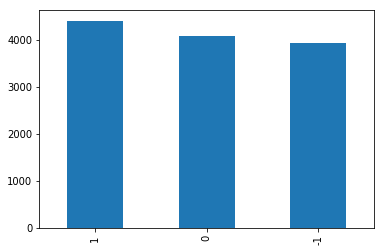

In [3]:

%matplotlib inline

import matplotlib.pyplot as plt

data['label'].value_counts().plot(kind="bar")
plt.show()


In [4]:
# train/test data split
train, test = train_test_split(data, test_size=0.2)


#### B. Feature Extraction
  i. We need to convert text data into numerical feature vectors
  
  Most of the algorithms expect numerical data rather than raw (a sequence of symbols). This process is called vectorization -- turning text documents into numerical representation. This whole process comprises of - tokenization, counting and normalization of data ( More specifically called prcess of Bag of Words). The document will be represented by the occurrences of words in the document rather than the relative position of them.
  
Let us have a closer look into vectorization

In [8]:
sample_train_data = ['Dispute delays National Assembly formation process',
              'Country is looking to encourage entrepreneurs and startup process',
              'Airline fuel surcharges to go up from Tuesday'] 

from sklearn.feature_extraction.text import CountVectorizer
# instantiate Vectorizer
vec = CountVectorizer()

# feed/learn the 'vocabulary' of the training data
vec.fit(sample_train_data)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

Looking at the definition above, the `CountVectorizer` simply make whole words lowercase, remove duplicates, and remove single word characters as suggested by regex.

In [9]:
# current fitted vocabulary
vec.get_feature_names()

['airline',
 'and',
 'assembly',
 'country',
 'delays',
 'dispute',
 'encourage',
 'entrepreneurs',
 'formation',
 'from',
 'fuel',
 'go',
 'is',
 'looking',
 'national',
 'process',
 'startup',
 'surcharges',
 'to',
 'tuesday',
 'up']

Let us create a document-term matrix. This simply describes the occurence of terms collection of documents.

In [10]:
# transform training data into a 'document-term matrix'
sample_train_dtm = vec.transform(sample_train_data)
sample_train_dtm

<3x21 sparse matrix of type '<class 'numpy.int64'>'
	with 23 stored elements in Compressed Sparse Row format>

Looking at the output, we can see that it creates a matrix with 3 rows and 21 columns.
 - Here, 3 colums because we have three documents all together
 - And, 21 rows because we have 21 terms (learned during fitting step above)

In [11]:
# let's observe the dense matrix
sample_train_dtm.toarray()

array([[0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
       [0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1]])

In [12]:
# Let us see the complete data map using pandas
import pandas as pd
pd.DataFrame(sample_train_dtm.toarray(), columns=vec.get_feature_names())

airline  and  assembly  country  delays  dispute  encourage  entrepreneurs  \
0  0        0    1         0        1       1        0          0               
1  0        1    0         1        0       0        1          1               
2  1        0    0         0        0       0        0          0               

   formation  from ...  go  is  looking  national  process  startup  \
0  1          0    ...  0   0   0        1         1        0         
1  0          0    ...  0   1   1        0         1        1         
2  0          1    ...  1   0   0        0         0        0         

   surcharges  to  tuesday  up  
0  0           0   0        0   
1  0           1   0        0   
2  1           1   1        1   

[3 rows x 21 columns]

You can see that most of the feature values are `ZEROs`. Why is that? Because most of the documents can be represented by small sets of words. Suppose, you have collected almost 100 reviews (documents) from a site. Then, there could be all together 1000 unique words (corpus) and a single review (single document) might have 10 unique words. right?

Storing such a big number of `ZEROs` does not make sense. So, scikit-learn internally uses `scipy.sparse` package to store such a matrix in memory and it also speed up the operations.

In [25]:
# let us now test our model with new example 
sample_test_data = ['Country is looking to encourage agriculture schemes']

In [26]:
# transform testing data into a document-term matrix (using existing vocabulary)
sample_test_dtm = vec.transform(sample_test_data)
sample_test_dtm.toarray()

array([[0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0]])

In [27]:
# examine the vocabulary and document-term matrix together
pd.DataFrame(sample_test_dtm.toarray(), columns=vec.get_feature_names())

airline  and  assembly  country  delays  dispute  encourage  entrepreneurs  \
0        0    0         0        1       0        0          1              0   

   formation  from ...  go  is  looking  national  process  startup  \
0          0     0 ...   0   1        1         0        0        0   

   surcharges  to  tuesday  up  
0           0   1        0   0  

[1 rows x 21 columns]

##### Problem with `CountVectorizer` **

Let's calcuate TfiDF for our sample train data above.

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vec = TfidfVectorizer()
sample_train_tfidf = tfidf_vec.fit_transform(sample_train_data)

In [29]:
pd.DataFrame(sample_train_tfidf.toarray(), columns=tfidf_vec.get_feature_names())

airline       and  assembly   country    delays   dispute  encourage  \
0  0.000000  0.000000  0.423394  0.000000  0.423394  0.423394   0.000000   
1  0.000000  0.350139  0.000000  0.350139  0.000000  0.000000   0.350139   
2  0.363255  0.000000  0.000000  0.000000  0.000000  0.000000   0.000000   

   entrepreneurs  formation      from    ...           go        is   looking  \
0       0.000000   0.423394  0.000000    ...     0.000000  0.000000  0.000000   
1       0.350139   0.000000  0.000000    ...     0.000000  0.350139  0.350139   
2       0.000000   0.000000  0.363255    ...     0.363255  0.000000  0.000000   

   national   process   startup  surcharges        to   tuesday        up  
0  0.423394  0.322002  0.000000    0.000000  0.000000  0.000000  0.000000  
1  0.000000  0.266290  0.350139    0.000000  0.266290  0.000000  0.000000  
2  0.000000  0.000000  0.000000    0.363255  0.276265  0.363255  0.363255  

[3 rows x 21 columns]

Let us discuss few questions regarding feature engineering.

#### Why do you need to vectorize the words?
 - Raw text data can not be directly fed into machine learning model. So, text to vector conversion PIPE-line consists of following process:

    * Tokenization : When we convert our text into list of words by removing stop words and punctuations, we assign individual string an id value.
     
    * Frequency counting :  We count the occurence of individual token into each of the document.
    * Normalizing :  We reduce the importance of token having frequent occurence in majority of documents by giving it lower weight.

  At the end, the token occurrene frequency is our feature for the model.reated as a feature.
  
####  Why do you need to do data standardization?
   - 

### C. Choose estimator

I will be using `SVM` as my estimator. We will not talk details on SVM because it might take long hours to understand the algorithms.
In brief, `linear SVM` tries to find an optimal vector ( a line) sperating two data points i.e classifying data. 


In [11]:
# news_classifier.py
import pickle
import csv
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm

class NewsClassification:
    def __init__(self):
        self.train_data = []
        self.train_labels = []
        self.test_data = []
        self.test_labels = []

        self.train_vectors = None
        self.test_vectors = None
        self.vectorizer = TfidfVectorizer()
        self.model = None

    def prepare_feature_vectors(self):
        # Train the feature vectors
        self.train_vectors = self.vectorizer.fit_transform(self.train_data)
        # Apply model on test data
        # : since they have already been fit to the training set
        self.test_vectors = self.vectorizer.transform(self.test_data)

    def prepare_model(self):
        self.model = svm.SVC(kernel='linear', class_weight="balanced")
        self.model.fit(self.train_vectors, self.train_labels)


if __name__ == '__main__':
    news_classifier = NewsClassification()
    data = pd.read_csv(
        'news_corpus/data.csv',
        names=['text', 'label'], dtype={'label': object})

    data = data[data['label'].map(len) <= 2]
    train, test = train_test_split(data, test_size=0.1)

    news_classifier = NewsClassification()
    news_classifier.train_data, news_classifier.train_labels =\
        train['text'], train['label']
    news_classifier.test_data, news_classifier.test_labels =\
        test['text'], test['label']

    news_classifier.prepare_feature_vectors()
    news_classifier.prepare_model()
    

#### D.1 Cross Validation for model selection
We would like to see whether Naive Bayes classifier or SVM is suitable for our data.

In [12]:
from sklearn.model_selection import cross_val_score
# cross validation score for Naive Bayes Classifier
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
print(cross_val_score(nb, news_classifier.train_vectors,
        news_classifier.train_labels, cv=10, scoring='accuracy').mean())


0.716316740628


In [13]:
# cross validation score for SVM
svm_model = svm.SVC(kernel='linear')
print(cross_val_score(svm_model, news_classifier.train_vectors,
        news_classifier.train_labels,cv=10, scoring='accuracy').mean())

0.74816864608


##### We saw that SVM is performing better than Naive Bayes classifier

#### D.2 Cross Validation for Paramters tuning

Until now, we are looking at training data to measure the accuracy of our model. But, there are also other parameters which are not the part of model training process. These parameters are called hyperparameters, which defines areas like - the complexity of model and how fast the model should learn. So, Hyperparameters can be defined as knobs or levels we fed for model building. 
On the other hand, model parameters are the properties that are learnt during training by the model. For example, if we are looking for Natural Lanuage processing model: word frequency, sentence length or n-grams per word are Model parameters.
During model development, we try to optimize model parameters looking into the performance of some loss function whereas optimizing hyperpameters is handled by investigatin various settings of the parameter values and located only after we observe the model accuracy. 
In this process, we will observe variations of SVM hyper-parameters "kernel”, "gamma" and "C" in order to get best model performing values.


GridSearchCV splits your given data input into Train and CV set and train algorithm with train set searching for the best hyperparameters using the CV set.

In [ ]:
import numpy as np
from sklearn.grid_search import GridSearchCV


param_grid = [
  {'C': [0.01, 0.1, 1, 10, 100], 'kernel': ['linear']},
  {'C': [0.01, 0.1, 1, 10, 100], 'gamma': np.logspace(-3, 0.1, 4), 'kernel': ['rbf']},
 ]

clf = GridSearchCV(svm.SVC(), param_grid,  cv=10,)
clf = clf.fit(news_classifier.train_vectors, news_classifier.train_labels)
print("Best estimator found by grid search:")
print(clf.best_estimator_)

/home/leapfrong/workspace/envs/envpractice/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/leapfrong/workspace/envs/envpractice/lib/python3.5/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [10]:
# Best parameters for the model found using grid search
print('Best C:',clf.best_estimator_.C) 
print('Best Kernel:',clf.best_estimator_.kernel)
print('Best Gamma:',clf.best_estimator_.gamma)

Best C: 1
Best Kernel: linear
Best Gamma: auto


#### E. Prediction with test data

In [12]:
# let's run prediction with our test data
# Predict new data with model loaded from disk
prediction = clf.best_estimator_.predict(news_classifier.test_vectors)
# prediction = news_classifier.model.predict(news_classifier.test_vectors)

test['prediction'] = prediction

test.tail(5)

/home/leapfrong/workspace/envs/envpractice/lib/python3.5/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


text  \
1792   Honda splits Acura into its own division to revitalize brand                     
12656  Low Quality.                                                                     
9941   Titanfall on Xbox One: Frame-Rate Is Uneven, Struggles A Lot Even At 792p  ...   
6939   Colorado made $3.5m 'pot' tax in January                                         
11696  Great pork sandwich.                                                             

      label prediction  
1792   1     1          
12656  -1    -1         
9941   -1    -1         
6939   0     0          
11696  1     1

### Analysis

##### i. Accuracy
  - It measures percentage of correct predictions .i.e the number of correct predictions
 made by our model divided by the total number of predictions.

In [7]:
print(clf.best_estimator_.score(
        news_classifier.test_vectors, news_classifier.test_labels))


0.731187122736


In [8]:
# let's also look at the best score for training data derived from cross validation

print(clf.best_estimator_.best_score_)

0.899859098229


####  NOTE : Test data accuracy is near to cross validation accuracy.

##### ii. Confusion Matrix
  - This matrix helps you to understand the types of errors made by our classifier.

In [7]:
from sklearn import metrics
conf_mat = metrics.confusion_matrix(
    news_classifier.test_labels, prediction,
    labels=['1', '-1', '0']
)
print(conf_mat)

NameError: name 'prediction' is not defined

* Here, we have 222 (128+94) misclassified data out of 1000.

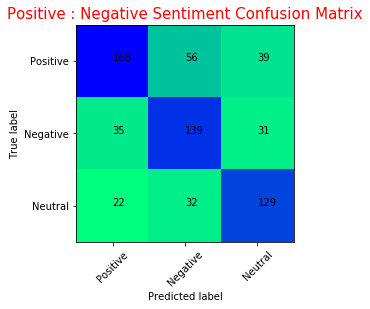

In [14]:
# Let's plot the matrix so that it will be more easier to see the model performance
import matplotlib.pyplot as plt
import numpy as np

plt.clf()
img = plt.imshow(conf_mat, interpolation='nearest')
img.set_cmap('winter_r')
class_names = ['Positive', 'Negative', 'Neutral']
plt.title('Positive : Negative Sentiment Confusion Matrix', fontsize="15", color="red")
plt.ylabel('True label')
plt.xlabel('Predicted label')

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
conf_labels = [['TP', 'FN'], ['FP', 'TN']]
for i in range(3):
    for j in range(3):
        plt.text(j, i, str(conf_mat[i][j]))
plt.show()



TP = True positive , FN = False Negative, 
 - TP_A (168) : sentiments our model thinks are "positive" and are "positive" in reality.
 - FN_A (56 + 39 = 95) : sentiments our model thinks are "negative" or "neutral" but they are "positive".
 - FP_A (35 + 22 = 57) : sentiments our model thinks are "positive" but they are "negative" or "neutral" in reality.
 - TP_B (139) : sentiments our model thinks are "negative" and are "negative" in reality.
 - FN_B (35 + 31 = 66) : sentiments our model thinks are "positive" or "neutral" but they are "negative" in reality.
 - FP_B (56 + 32 = 88) : sentiments our model thinks are "negative" but they are "positive" or "neutral" in reality.